In [1]:
using Pkg 
Pkg.activate("..")

  Activating project at `~/code/PhasorNetworks.jl`


In [2]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

In [3]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test, LuxCUDA, CUDA
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using PhasorNetworks: bind
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

[ Info: Precompiling PhasorNetworks [c32d742c-e486-48f1-8804-9f6fb4d3f42c] (cache misses: wrong dep version loaded (2), mismatched flags (14), include_dependency fhash change (2))


In [4]:
CUDA.allowscalar(false)

In [5]:
solver_args = Dict(:adaptive => false, :dt => 0.01)

spk_args = SpikingArgs(threshold = 0.001,
                    solver=Tsit5(), 
                    solver_args = solver_args)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [6]:
cdev = cpu_device()
gdev = gpu_device()

(::CUDADevice{Nothing, Missing}) (generic function with 1 method)

In [7]:
args = Args(use_cuda = true)

Args(0.0003, 128, 10, true, Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e))

# Static

In [8]:
x_in = random_symbols(args.rng, (1024, 10, 16)) |> gdev;

In [9]:
y_out = random_symbols(args.rng, (1024, 10, 16)) |> gdev;

In [10]:
import .PhasorNetworks: ResidualBlock

In [11]:
layer = Chain(
    #x -> x,
    ResidualBlock((1024, 1024), soft_angle),)

Chain(
    layer_1 = ResidualBlock(
        ff = Chain(
            layer_1 = PhasorDense(
                layer = Dense(1024 => 1024, use_bias=false),  # 1_048_576 parameters
                bias = ComplexBias((1024,)),      # 2_048 parameters
            ),
        ),
    ),
)         # Total: 1_050_624 parameters,
          #        plus 0 states.

In [12]:
ps, st = Lux.setup(args.rng, layer) .|> gdev

((layer_1 = (ff = (layer_1 = (layer = (weight = Float32[0.03999645 -0.050390787 … -0.03505738 -0.03834864; 0.0057544755 0.05269876 … -0.0034123152 -0.006475543; … ; -0.015822388 -0.006579278 … -0.001790984 0.010609971; 0.04013447 -0.048627794 … 0.04237618 -0.044667974],), bias = (bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])),),),), (layer_1 = (ff = (layer_1 = (layer = NamedTuple(), bias = NamedTuple()),),),))

In [13]:
y, _ = layer(x_in, ps, st)

(Float32[0.17648125 0.17143881 … -0.042914033 -0.92261124; -0.3889128 0.21425176 … 0.3877014 -0.3594643; … ; -0.30360895 0.05491197 … 0.9007621 -0.8737031; -0.67249525 -0.51433325 … 0.5945096 -0.93786544;;; 0.39490652 0.98572767 … 0.9449401 0.108332634; 0.022489905 0.06579828 … -0.20670795 -0.20193005; … ; 0.5653043 0.3172642 … -0.22579122 -0.6491407; -0.74608237 0.12633133 … 0.8076612 0.8082788;;; -0.333838 0.45530105 … -0.01234287 -0.8092808; 0.55305314 -0.8485942 … 0.23099387 -0.115721345; … ; -0.6813976 0.8913177 … -0.70882297 -0.95423657; 0.44300342 -0.62802106 … -0.4512828 0.78930783;;; … ;;; 0.8079066 0.6567259 … 0.7997539 0.08048868; -0.53069556 -0.3378145 … 0.85280824 -0.8582351; … ; 0.37684512 0.35358298 … 0.93945503 0.5607575; 0.26965618 -0.9989554 … -0.7134336 -0.53969944;;; 0.8004072 -0.31899452 … 0.40172184 0.8287331; -0.8812231 -0.95612645 … 0.20389307 -0.0031297207; … ; 0.4040227 0.19059122 … -0.044908047 -0.523514; 0.5205791 0.9625895 … -0.39890987 0.5729673;;; 0.95265

In [14]:
direct_y, _ = layer.layers[1].ff(x_in, ps.layer_1.ff, st.layer_1.ff);

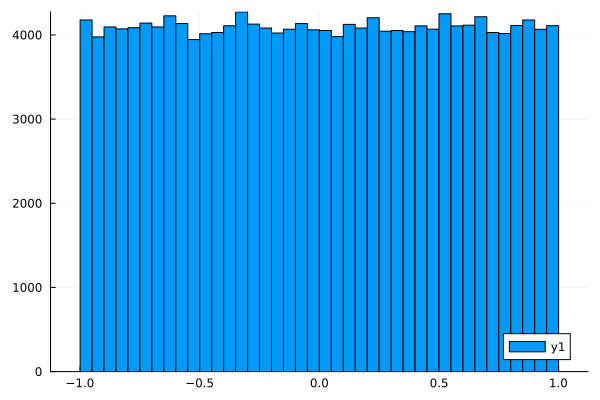

In [15]:
histogram(vec(cdev(y)))

# Dynamic

In [16]:
spk_args = SpikingArgs()

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [17]:
xtrain = phase_to_train(x_in, spk_args=spk_args, repeats=10)

SpikeTrainGPU{3}(CartesianIndex{3}[CartesianIndex(1, 1, 1), CartesianIndex(2, 1, 1), CartesianIndex(3, 1, 1), CartesianIndex(4, 1, 1), CartesianIndex(5, 1, 1), CartesianIndex(6, 1, 1), CartesianIndex(7, 1, 1), CartesianIndex(8, 1, 1), CartesianIndex(9, 1, 1), CartesianIndex(10, 1, 1)  …  CartesianIndex(1015, 10, 16), CartesianIndex(1016, 10, 16), CartesianIndex(1017, 10, 16), CartesianIndex(1018, 10, 16), CartesianIndex(1019, 10, 16), CartesianIndex(1020, 10, 16), CartesianIndex(1021, 10, 16), CartesianIndex(1022, 10, 16), CartesianIndex(1023, 10, 16), CartesianIndex(1024, 10, 16)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  163831, 163832, 163833, 163834, 163835, 163836, 163837, 163838, 163839, 163840], Float32[0.4544829, 0.17357457, 0.6611862, 0.3216616, 0.66958964, 0.25858545, 0.1385169, 0.16643864, 0.033940017, 0.527015  …  9.648087, 9.936634, 9.15895, 9.695121, 9.635818, 9.749306, 9.575124, 9.838406, 9.41879, 9.57169], (1024, 10, 16), 163840, 0.0f0)

In [18]:
xc = SpikingCall(xtrain, spk_args, (0.0f0, 10.0f0))

SpikingCall(SpikeTrainGPU{3}(CartesianIndex{3}[CartesianIndex(1, 1, 1), CartesianIndex(2, 1, 1), CartesianIndex(3, 1, 1), CartesianIndex(4, 1, 1), CartesianIndex(5, 1, 1), CartesianIndex(6, 1, 1), CartesianIndex(7, 1, 1), CartesianIndex(8, 1, 1), CartesianIndex(9, 1, 1), CartesianIndex(10, 1, 1)  …  CartesianIndex(1015, 10, 16), CartesianIndex(1016, 10, 16), CartesianIndex(1017, 10, 16), CartesianIndex(1018, 10, 16), CartesianIndex(1019, 10, 16), CartesianIndex(1020, 10, 16), CartesianIndex(1021, 10, 16), CartesianIndex(1022, 10, 16), CartesianIndex(1023, 10, 16), CartesianIndex(1024, 10, 16)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  163831, 163832, 163833, 163834, 163835, 163836, 163837, 163838, 163839, 163840], Float32[0.4544829, 0.17357457, 0.6611862, 0.3216616, 0.66958964, 0.25858545, 0.1385169, 0.16643864, 0.033940017, 0.527015  …  9.648087, 9.936634, 9.15895, 9.695121, 9.635818, 9.749306, 9.575124, 9.838406, 9.41879, 9.57169], (1024, 10, 16), 163840, 0.0f0), Neuron parameters: Period 

In [19]:
layer.layers[1].ff

Chain(
    layer_1 = PhasorDense(
        layer = Dense(1024 => 1024, use_bias=false),  # 1_048_576 parameters
        bias = ComplexBias((1024,)),              # 2_048 parameters
    ),
)         # Total: 1_050_624 parameters,
          #        plus 0 states.

In [20]:
denseout, _ = layer.layers[1].ff(xc, ps.layer_1.ff, st.layer_1.ff)

(SpikingCall(SpikeTrainGPU{3}(CartesianIndex{3}[CartesianIndex(1, 1, 1), CartesianIndex(2, 1, 1), CartesianIndex(3, 1, 1), CartesianIndex(4, 1, 1), CartesianIndex(5, 1, 1), CartesianIndex(6, 1, 1), CartesianIndex(7, 1, 1), CartesianIndex(8, 1, 1), CartesianIndex(9, 1, 1), CartesianIndex(10, 1, 1)  …  CartesianIndex(1015, 10, 16), CartesianIndex(1016, 10, 16), CartesianIndex(1017, 10, 16), CartesianIndex(1018, 10, 16), CartesianIndex(1019, 10, 16), CartesianIndex(1020, 10, 16), CartesianIndex(1021, 10, 16), CartesianIndex(1022, 10, 16), CartesianIndex(1023, 10, 16), CartesianIndex(1024, 10, 16)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  163831, 163832, 163833, 163834, 163835, 163836, 163837, 163838, 163839, 163840], Float32[1.8888166, 1.8757503, 1.7440789, 1.9192319, 1.7555296, 1.7468548, 1.5259082, 1.8408945, 1.7632456, 1.7606823  …  10.726177, 10.884097, 10.768331, 10.77337, 10.787992, 10.823779, 10.875228, 10.6937475, 10.833563, 10.73871], (1024, 10, 16), 163840, 0.25f0), Neuron parameters

In [21]:
p_denseout = train_to_phase(denseout);

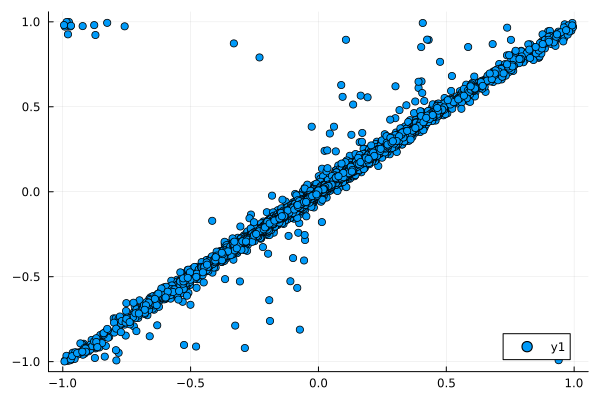

In [22]:
scatter(vec(cdev(direct_y)[:,:,1]), vec(cdev(p_denseout)[:,:,1,end-1]))

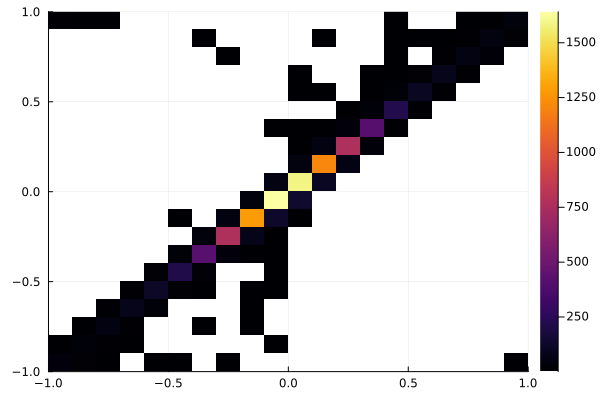

In [ ]:
#what we compute from the static & dynamic FF blocks matches
histogram2d(vec(cdev(direct_y)[:a,:,1]), vec(cdev(p_denseout)[:,:,1,end-1]))

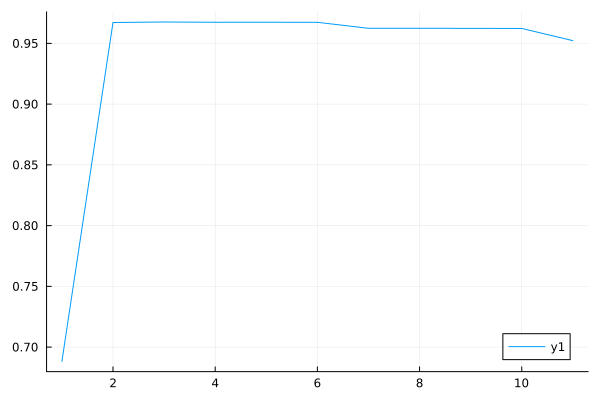

In [24]:
plot(cycle_correlation(cdev(direct_y)[:,:,1], cdev(p_denseout)[:,:,1,:]))

In [42]:
bindin = p_denseout[:,:,:,end-1];

In [43]:
bindout = v_bind(x_in, bindin);

In [44]:
bindout |> size

(1024, 10, 16)

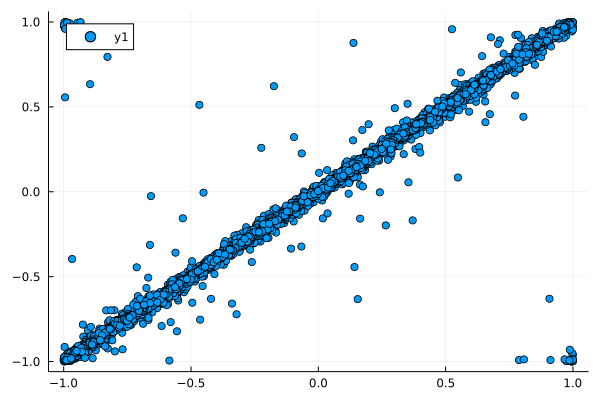

In [45]:
scatter(vec(cdev(bindout)[:,:,1]), vec(cdev(y[:,:,1])))

In [47]:
y_s, _ = layer(xc, ps, st)

(SpikingCall(SpikeTrainGPU{3}(CartesianIndex{3}[CartesianIndex(1, 1, 1), CartesianIndex(2, 1, 1), CartesianIndex(3, 1, 1), CartesianIndex(4, 1, 1), CartesianIndex(5, 1, 1), CartesianIndex(6, 1, 1), CartesianIndex(7, 1, 1), CartesianIndex(8, 1, 1), CartesianIndex(9, 1, 1), CartesianIndex(10, 1, 1)  …  CartesianIndex(1015, 10, 16), CartesianIndex(1016, 10, 16), CartesianIndex(1017, 10, 16), CartesianIndex(1018, 10, 16), CartesianIndex(1019, 10, 16), CartesianIndex(1020, 10, 16), CartesianIndex(1021, 10, 16), CartesianIndex(1022, 10, 16), CartesianIndex(1023, 10, 16), CartesianIndex(1024, 10, 16)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  163831, 163832, 163833, 163834, 163835, 163836, 163837, 163838, 163839, 163840], Float32[3.092484, 2.7983155, 3.1544905, 2.9900107, 3.1743581, 2.7544017, 3.4131618, 2.7562962, 2.545766, 3.0368452  …  11.245595, 10.691865, 10.797679, 11.362831, 11.294943, 10.9557705, 11.320554, 11.402711, 11.122523, 11.181992], (1024, 10, 16), 163840, 0.5f0), Neuron parameters:

In [49]:
size(y)

(1024, 10, 16)

In [51]:
size(y)

(1024, 10, 16)

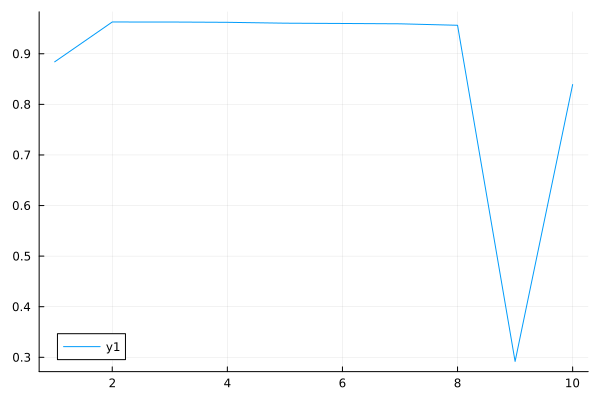

In [54]:
plot(cycle_correlation(cdev(y[:,:,1]), cdev(train_to_phase(y_s))[:,:,1,:]))